# Simple Attack

In this notebook, we will examine perhaps the simplest possible attack on an individual's private data and what the WhiteNoise library can do to mitigate it.

In [1]:
import os 
import numpy as np
import pandas as pd

# load data
data = pd.read_csv(os.path.join('data', 'pums_10000.csv'))
n_obs = data.shape[0]

person_of_interest = data.iloc[0]
print('person of interest:\n\n{0}'.format(person_of_interest))


person of interest:

sex           0.0
age          45.0
educ          6.0
income     6000.0
married       1.0
race          1.0
Name: 0, dtype: float64


Consider an attacker who knows everything about the data except for the person of interest's (POI) income, which is considered private. They can back out the individual's income very easily, just from asking for the mean overall mean income.    

In [2]:
# they already know everyone else's income
known_mean = np.mean(data.iloc[1:]['income'])
known_obs = n_obs - 1

# overall mean
overall_mean = np.mean(data['income'])

# back out POI's income
poi_income = overall_mean * n_obs - known_obs * known_mean
print('poi_income: {0}'.format(poi_income))

poi_income: 6000.0


The attacker now knows with certainty that the POI has an income of \\$6,000. Let's see what happens if the attacker were made to interact with the data through WhiteNoise and was given a privacy budget of $\epsilon = 1$. We will assume that the attacker is reasonably familiar with differential privacy and believes that they should use tighter data bounds than they know are actually in the data in order to get a less noisy estimate. They will need to update their `known_mean` accordingly.

We will also assume that the attacker will spend all of their privacy budget on a single query. This assumption can be changed by changing the `n_queries` variable below. 

We will be using `n_sims` to simulate the process a number of times to get a sense for various possible outcomes for the attacker. In practice, they would see the result of only one simulation.

In [3]:
import opendp.whitenoise.core as wn

data_path = os.path.join('data', 'pums_10000.csv')
var_names = ['sex', 'age', 'educ', 'income', 'married', 'race']

# update known_mean
known_mean = np.mean(np.clip(data.iloc[1:]['income'], 0, 100_000))

# initialize vector to store estimated overall means
n_sims = 10_000
n_queries = 1
poi_income_ests = []
estimated_means = []

# get estimates of overall means
for i in range(n_sims):
    query_means = []
    with wn.Analysis() as analysis:
        income = wn.resize(
            wn.to_float(wn.Dataset(path = data_path, column_names = var_names)['income']),
            number_rows = n_obs,
            data_lower = 0.,
            data_upper = 100_000.)
        
        for j in range(n_queries):
            query_means.append(wn.dp_mean(
                data = income,
                privacy_usage = {'epsilon': 1/n_queries}))
    analysis.release()

    # get estimates of POI income
    estimated_means.append(np.mean([mean.value for mean in query_means]))
    poi_income_ests.append(estimated_means[i] * n_obs - known_obs * known_mean)

In [6]:
# get mean of estimates
print('Known Mean Income (after truncation): {0}'.format(known_mean))
print('Observed Mean Income: {0}'.format(np.mean(estimated_means)))
print('Estimated POI Income: {0}'.format(np.mean(poi_income_ests)))
print('True POI Income: {0}'.format(person_of_interest['income']))

Known Mean Income (after truncation): 26886.001600160016
Observed Mean Income: 26883.91416432742
Estimated POI Income: 6011.64327417759
True POI Income: 6000.0


We see empirically that, in expectation, the attacker can get a reasonably good estimate of POI's income. However, they will rarely (if ever) get it exactly and would have no way of knowing if they did.

Below is a plot showing an the empirical distribution of estimates of POI income.

[Text(0.5, 0, 'Estimated POI income')]

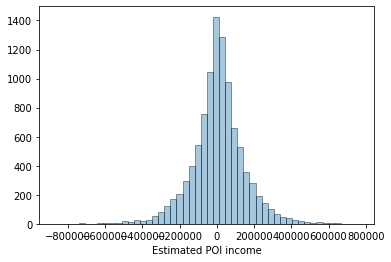

In [7]:
import seaborn as sns

# distribution of POI income
ax = sns.distplot(poi_income_ests, kde = False, hist_kws = dict(edgecolor = 'black', linewidth = 1))
ax.set(xlabel = 'Estimated POI income')